In [33]:
%pip install requests


[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *

from protocol_getter import ProtocolGetter

### Knesset members list

In [2]:
knesset_members_df = pd.read_csv('kns_csv_files\kns_person.csv')
first_names, last_names = knesset_members_df['FirstName'].to_list(), knesset_members_df['LastName'].to_list()
knesset_members = [' '.join([first_name, last_name]) for first_name, last_name in zip(first_names, last_names)]

### reading from all pickles

In [38]:
path = "results/"
knss = [20, 21, 22, 23, 24, 25]
categorys = [1, 2, 4, 6, 13]
agg_scores = []
warned = []
warning_score = []
kns_cat = []
KNS_to_Agg = {}
KNSCAT_to_Agg = {}
KNSCAT_to_amount = {}
CATAGORY_to_Agg = {}
number_of_sessions = 0
cms = pd.read_csv("kns_csv_files\kns_committeesession.csv")

for kns in knss:
    for cat in categorys:
        protocol_getter = ProtocolGetter(COMMITTEES_PATH, kns, kns, [cat]) ### retrieve all sessions_ids in the committee
        committee = protocol_getter.committee_ids[0]
        filtered = cms
        filtered = filtered[filtered.CommitteeID == committee]
        sesseions = filtered[["CommitteeSessionID", "text_parsed_filename"]].dropna()["CommitteeSessionID"].tolist()
        agg_scores_per_sess = []
        for session in sesseions:
            try: # process only if the .pkl exist
                with open(f'{path}finetune_{session}.pkl', 'rb') as f:
                    tmp_dct = pickle.load(f)
                number_of_sessions += 1
            except FileNotFoundError:
                continue
            speaker_cnt = tmp_dct['speaker_cnt']
            n_speakers = tmp_dct['n_speakers']
            n_speaks = tmp_dct['n_speaks']
            warnings = tmp_dct['warnings']
            for member, w1w2w3 in warnings.items(): # find warned members
                if sum(w1w2w3) != 0 and member in knesset_members:
                    W = (w1w2w3[0] + w1w2w3[1]*2 + w1w2w3[2]*3)
                    if member in speaker_cnt.keys():
                        times = speaker_cnt[member]
                    else:
                        for speaker in speaker_cnt.keys():
                            if member in speaker or speaker in member:
                                times = speaker_cnt[speaker]
                    mk = n_speaks*times
                    logn = np.log2(n_speakers)
                    warning_score = (W*logn)/mk
                    warned.append((member, w1w2w3, kns, CATEGORY_ID_TO_NAME[cat], session, warning_score))
                elif member in speaker_cnt: # find participated unwarned member in the session
                    warned.append((member, [0, 0, 0], kns, CATEGORY_ID_TO_NAME[cat], session, 0))
            agg_score = tmp_dct['agg_score'] ### updating agg score of the session
            agg_scores_per_sess.append(agg_score)
            tmp_val = KNS_to_Agg.get(kns, [])
            tmp_val.append(agg_score)
            KNS_to_Agg[kns] = tmp_val
            tmp_val = CATAGORY_to_Agg.get(CATEGORY_ID_TO_NAME[cat], [])
            tmp_val.append(agg_score)
            CATAGORY_to_Agg[CATEGORY_ID_TO_NAME[cat]] = tmp_val
            knscat = f'{kns}_{CATEGORY_ID_TO_NAME[cat]}'
            tmp_val = KNSCAT_to_Agg.get(knscat, [])
            tmp_val.append(agg_score)
            KNSCAT_to_Agg[knscat] = tmp_val
            tmp_val = KNSCAT_to_amount.get(knscat, 0)
            tmp_val += 1
            KNSCAT_to_amount[knscat] = tmp_val
        kns_cat.append(f'{kns}_{CATEGORY_ID_TO_NAME[cat]}')

### averaging all agg scores by relevant keys
avg_agg_kns = {}
for kns, agg_lst in KNS_to_Agg.items():
    avg_agg_kns[str(kns)] = np.average(agg_lst)
avg_agg_cat = {}
for cat, agg_lst in CATAGORY_to_Agg.items():
    avg_agg_cat[cat] = np.average(agg_lst)
avg_agg_knscat = {}
for knscat, agg_lst in KNSCAT_to_Agg.items():
    avg_agg_knscat[knscat] = np.average(agg_lst)

### amount of proccessed protocols

In [39]:
# amoint of proccessed protocols
KNSCAT_to_amount

{'20_knesset': 418,
 '20_finance': 428,
 '20_defense': 128,
 '20_law and order': 48,
 '20_science': 198,
 '21_finance': 28,
 '21_defense': 6,
 '22_knesset': 4,
 '22_finance': 53,
 '22_defense': 7,
 '23_knesset': 120,
 '23_finance': 99,
 '23_defense': 70,
 '23_law and order': 40,
 '23_science': 34,
 '24_knesset': 126,
 '24_finance': 93,
 '24_defense': 65,
 '24_law and order': 9,
 '25_knesset': 15,
 '25_finance': 48,
 '25_defense': 6,
 '25_law and order': 26,
 '25_science': 3}

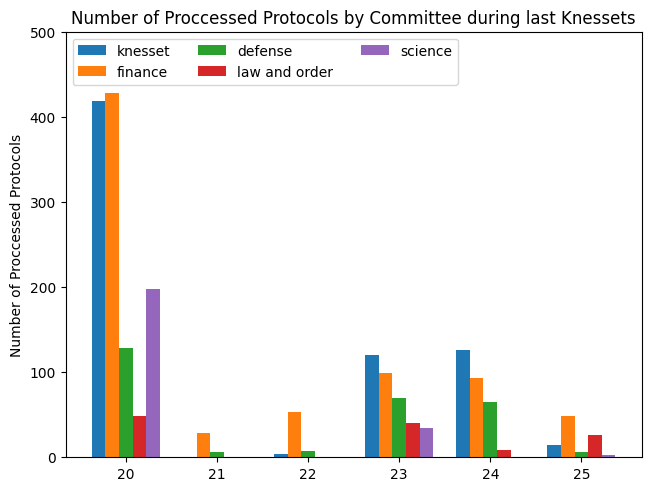

In [40]:
knasots_val_dct = {}
for knscat in kns_cat:
    tmp = knasots_val_dct.get(knscat[3:], [])
    amount = KNSCAT_to_amount.get(knscat, 0)
    tmp.append(amount)
    knasots_val_dct[knscat[3:]] = tmp


species = avg_agg_kns.keys()
penguin_means = knasots_val_dct


x = 2*np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Proccessed Protocols')
ax.set_title('Number of Proccessed Protocols by Committee during last Knessets')
ax.set_xticks(x + 2*width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 500)

plt.show()

In [41]:
number_of_sessions

2072

### agression score

In [42]:
ind = 0
knasots = {}
for k_c, agg in avg_agg_knscat.items():
    a = k_c[:2]
    tmp = knasots.get(a, [[], []])
    tmp[0].append(k_c)
    tmp[1].append(agg)
    knasots[a] = tmp
    ind += 1


In [43]:
knasots

{'20': [['20_knesset',
   '20_finance',
   '20_defense',
   '20_law and order',
   '20_science'],
  [0.062435793209082976,
   0.083762476181321,
   0.09847186313248266,
   0.09587102196492692,
   0.1345291523317308]],
 '21': [['21_finance', '21_defense'],
  [0.09732376797593767, 0.10907205227344535]],
 '22': [['22_knesset', '22_finance', '22_defense'],
  [0.06848054127064818, 0.09271834292100078, 0.07147779668120623]],
 '23': [['23_knesset',
   '23_finance',
   '23_defense',
   '23_law and order',
   '23_science'],
  [0.06702240519059487,
   0.11093427557873231,
   0.10593187087340114,
   0.07820645259199814,
   0.11937324496920387]],
 '24': [['24_knesset', '24_finance', '24_defense', '24_law and order'],
  [0.07051590929288168,
   0.10088879257516818,
   0.10613176144379781,
   0.07197967487642104]],
 '25': [['25_knesset',
   '25_finance',
   '25_defense',
   '25_law and order',
   '25_science'],
  [0.07240432160903616,
   0.11083634955158717,
   0.09380388383355563,
   0.103754385416

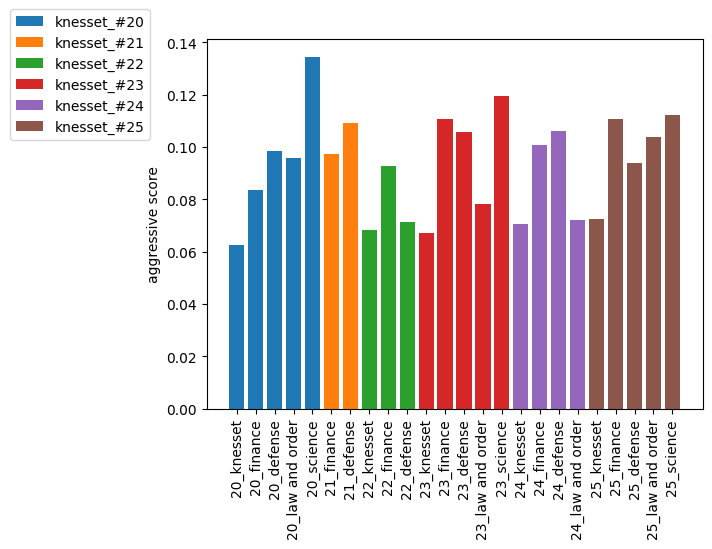

In [44]:
for kns, duo in knasots.items():
    plt.bar(duo[0], duo[1], label= f'knesset_#{kns}')
plt.ylabel("aggressive score")
plt.legend(bbox_to_anchor=(-0.1, 1.1))
plt.xticks(rotation = 90)
plt.show()

In [45]:
knasots_val_dct = {}
for knscat in kns_cat:
    tmp = knasots_val_dct.get(knscat[3:], [])
    agg = avg_agg_knscat.get(knscat, 0)
    tmp.append(np.round(agg, 3))
    knasots_val_dct[knscat[3:]] = tmp

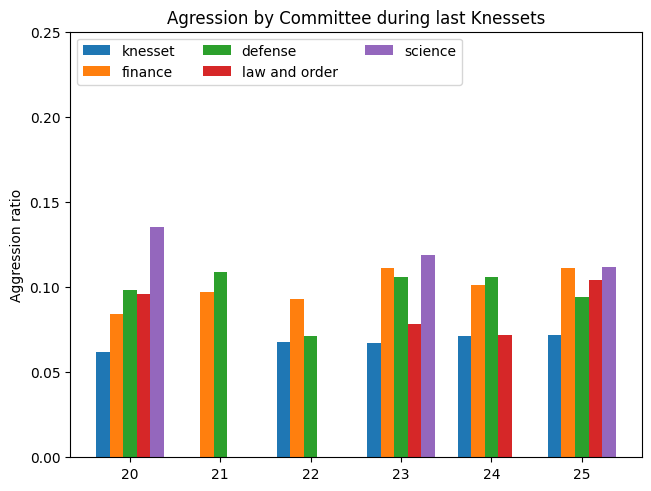

In [46]:

species = knasots.keys()
penguin_means = knasots_val_dct


x = 2*np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Aggression ratio')
ax.set_title('Agression by Committee during last Knessets')
ax.set_xticks(x + 2*width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.25)

plt.show()

Text(0, 0.5, 'aggressive score')

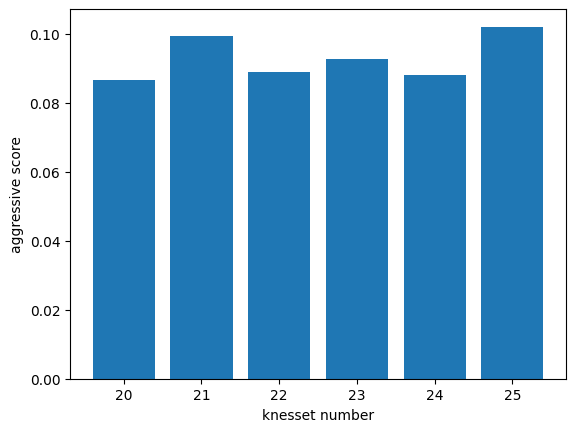

In [47]:
plt.bar(avg_agg_kns.keys(), avg_agg_kns.values())
plt.xlabel("knesset number")
plt.ylabel("aggressive score")

Text(0, 0.5, 'aggressive score')

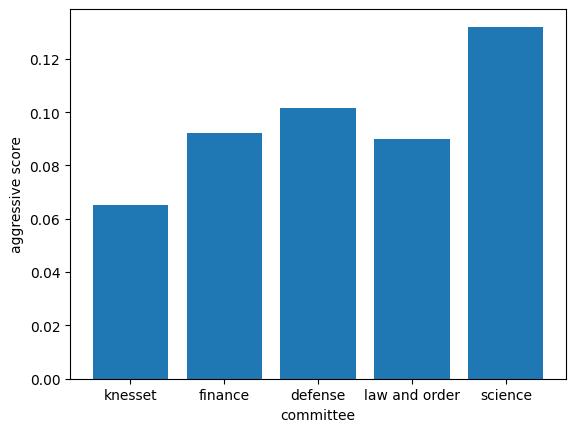

In [48]:
plt.bar(avg_agg_cat.keys(), avg_agg_cat.values())
plt.xlabel("committee")
plt.ylabel("aggressive score")

### warnings

In [49]:
warned

[('איתן כבל', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('צחי הנגבי', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('ישראל כץ', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('יולי יואל אדלשטיין', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('גדעון סער', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('יריב לוין', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('דוד ביטן', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('מכלוף מיקי זוהר', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('ירון מזוז', [0, 0, 0], 20, 'knesset', 565244, 0),
 ('יצחק וקנין', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('ישראל אייכלר', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('רוברט אילטוב', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('דוד ביטן', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('דניאל עטר', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('שי פירון', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('קארין אלהרר', [0, 0, 0], 20, 'knesset', 565253, 0),
 ("עיסאווי פריג'", [0, 0, 0], 20, 'knesset', 565253, 0),
 ('יואב קיש', [0, 0, 0], 20, 'knesset', 565253, 0),
 ('מכלוף מיקי זוהר', [0,

In [50]:
### create commulative score and warnings for members, committees and Knessets

warnings_by_member = {}
warnings_by_knesset = {}
warnings_by_category = {}
warning_score_by_member = {}
warning_score_by_knesset = {}
warning_score_by_category = {}
for member, w1w2w3, kns, cat, protocol, warning_score in warned:
    cur_by_member = warnings_by_member.get(member, [0, 0, 0])
    cur_by_kns = warnings_by_knesset.get(kns, [0, 0, 0])
    cur_by_cat = warnings_by_category.get(cat, [0, 0, 0])

    scr_by_member = warning_score_by_member.get(member, [])
    scr_by_kns = warning_score_by_knesset.get(kns, [])
    scr_by_cat = warning_score_by_category.get(cat, [])
    scr_by_member.append(warning_score)
    scr_by_kns.append(warning_score)
    scr_by_cat.append(warning_score)
    warning_score_by_member[member] = scr_by_member
    warning_score_by_knesset[kns] = scr_by_kns
    warning_score_by_category[cat] = scr_by_cat

    for i in range(3):
        cur_by_member[i] += w1w2w3[i]
        cur_by_kns[i] += w1w2w3[i]
        cur_by_cat[i] += w1w2w3[i]
    warnings_by_member[member] = cur_by_member
    warnings_by_knesset[kns] = cur_by_kns
    warnings_by_category[cat] = cur_by_cat


In [51]:
avg_warning_score_by_member = {}
for key, val in warning_score_by_member.items():
    avg_warning_score_by_member[key] = np.average(val)
avg_warning_score_by_knesset = {}
for key, val in warning_score_by_knesset.items():
    avg_warning_score_by_knesset[key] = np.average(val)
avg_warning_score_by_category = {}
for key, val in warning_score_by_category.items():
    avg_warning_score_by_category[key] = np.average(val)

In [52]:
avg_warning_score_by_knesset

{20: 0.00038502534158671285,
 21: 2.4925994307228084e-05,
 22: 7.648489957367915e-05,
 23: 0.0014764949351995175,
 24: 0.0004036331252211315,
 25: 0.00046935538683836144}

Text(0, 0.5, 'Average Warning Score')

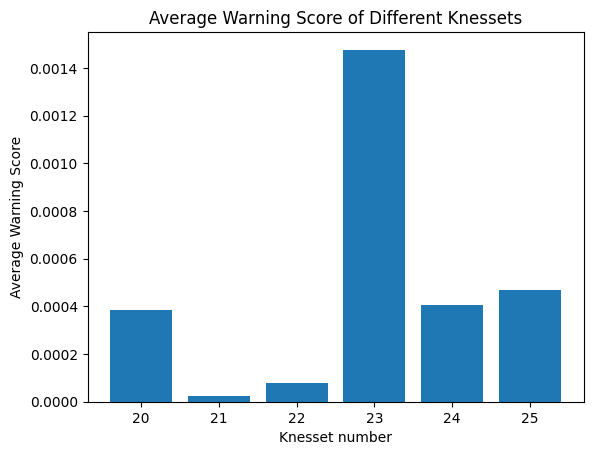

In [55]:
plt.bar(avg_warning_score_by_knesset.keys(), avg_warning_score_by_knesset.values())
plt.title("Average Warning Score of Different Knessets")
plt.xlabel("Knesset number")
plt.ylabel("Average Warning Score")

Text(0, 0.5, 'Average Warning Score')

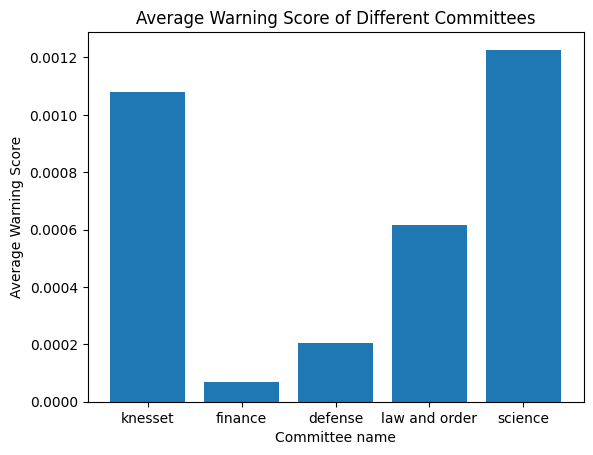

In [66]:
plt.bar(avg_warning_score_by_category.keys(), avg_warning_score_by_category.values())
plt.title("Average Warning Score of Different Committees")
plt.xlabel("Committee name")
plt.ylabel("Average Warning Score")

In [63]:
KNSCAT_to_amount

KNS_to_amount = {}
LawAndKnesset_to_amount = {}
for key, val in KNSCAT_to_amount.items():
    kns = key[:2]
    cat = key[3:]

    tmp = KNS_to_amount.get(kns, 0) + val
    KNS_to_amount[kns] = tmp

    if "law" in cat or "knesset" in cat or "science" in cat:
        tmp = LawAndKnesset_to_amount.get(kns, 0) + val
        LawAndKnesset_to_amount[kns] = tmp

In [64]:
KNS_to_amount

{'20': 1220, '21': 34, '22': 64, '23': 363, '24': 293, '25': 98}

<BarContainer object of 6 artists>

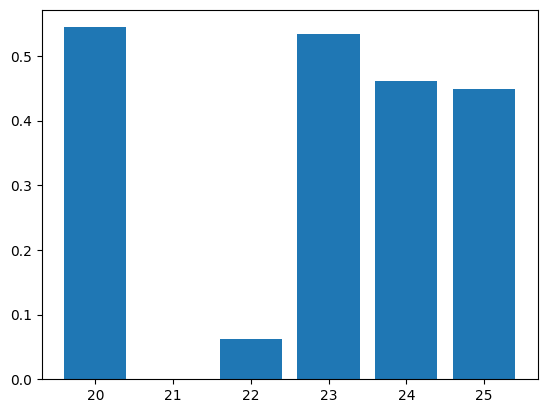

In [65]:
normed = {}
for key in KNS_to_amount.keys():
    normed[key] = LawAndKnesset_to_amount.get(key, 0)/KNS_to_amount[key]

plt.bar(normed.keys(), normed.values())

In [53]:
len(warning_score_by_member['שלמה קרעי'])

183

In [19]:
member = 'נאור שירי'
print(warnings_by_member[member])
print(len(warning_score_by_member[member]))

[2, 8, 4]
6


In [20]:
avg_WS_by_member = []
for member, WS in warning_score_by_member.items():
    avg_WS_by_member.append((member, np.average(WS)))
avg_WS_by_member.sort(key= lambda x: x[1], reverse= True)
avg_WS_by_member

[('ינון אזולאי', 4117103459.5268188),
 ('יוראי להב הרצנו', 1050235383.7283717),
 ('יסמין פרידמן', 510285303.9391298),
 ('מיכל רוזין', 62569946.37453312),
 ('נאור שירי', 56076466.69540673),
 ('אורלי לוי אבקסיס', 38059175.71208141),
 ('יוליה מלינובסקי', 34685879.55484977),
 ('מיכל מרים וולדיגר', 34139708.62513554),
 ('רם בן ברק', 32459222.645276085),
 ('חיים ילין', 8603390.851894354),
 ('משה טור פז', 4827471.738308743),
 ('ולדימיר בליאק', 3102656.0749158715),
 ("יואב סגלוביץ'", 2688179.1164855757),
 ('נעמה לזימי', 1686305.2910525962),
 ('יואב קיש', 1449747.480353007),
 ('סתיו שפיר', 1194854.198014925),
 ('גלעד קריב', 1131066.7237456131),
 ('אורית פרקש הכהן', 1017225.1286906447),
 ('אורן אסף חזן', 939720.568679309),
 ('קארין אלהרר', 893240.5082042152),
 ('דוד ביטן', 863894.7614993117),
 ('דוד אמסלם', 827511.4236550587),
 ('אורנה ברביבאי', 803596.384277546),
 ('שלמה קרעי', 634228.7140237594),
 ('תהלה פרידמן', 507629.6376033149),
 ("עיסאווי פריג'", 389069.8133599908),
 ('פנינה תמנו', 360658

In [21]:
warnings_by_knesset

{20: [396, 237, 68],
 21: [3, 0, 1],
 22: [18, 4, 5],
 23: [53, 31, 11],
 24: [95, 67, 34],
 25: [100, 142, 87]}

In [23]:
KNS_to_amount = {}
CAT_to_amount = {}
for key, val in KNSCAT_to_amount.items():
    kns = key[:2]
    cat = key[3:]

    tmp = KNS_to_amount.get(kns, 0) + val
    KNS_to_amount[kns] = tmp

    tmp = CAT_to_amount.get(cat, 0) + val
    CAT_to_amount[cat] = tmp

In [28]:
KNS_to_amount

{'20': 1220, '21': 34, '22': 64, '23': 363, '24': 293, '25': 98}

In [29]:
normed_warning1_by_knesset = {}
normed_warning2_by_knesset = {}
normed_warning3_by_knesset = {}
for key, val in warnings_by_knesset.items():
    normed_warning1_by_knesset[key] = val[0]/KNS_to_amount[str(key)]
    normed_warning2_by_knesset[key] = val[1]/KNS_to_amount[str(key)]
    normed_warning3_by_knesset[key] = val[2]/KNS_to_amount[str(key)]

<BarContainer object of 6 artists>

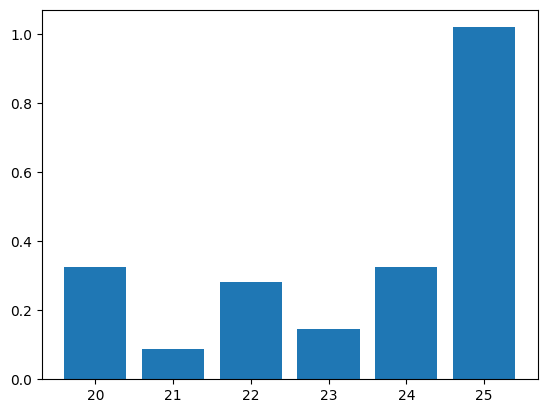

In [33]:
plt.bar(normed_warning1_by_knesset.keys(), normed_warning1_by_knesset.values())

<BarContainer object of 6 artists>

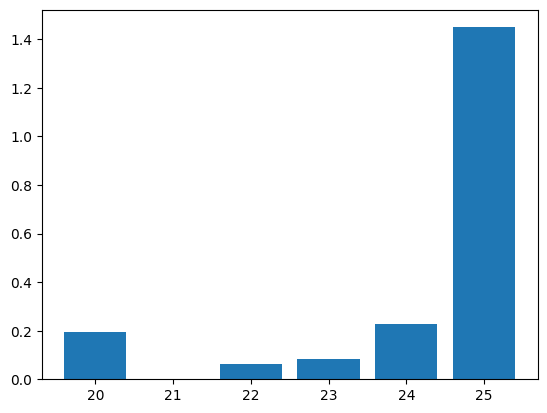

In [36]:
plt.bar(normed_warning2_by_knesset.keys(), normed_warning2_by_knesset.values())

In [32]:
normed_warning3_by_knesset

{20: 0.05573770491803279,
 21: 0.029411764705882353,
 22: 0.078125,
 23: 0.030303030303030304,
 24: 0.11604095563139932,
 25: 0.8877551020408163}